In [10]:
import os
print(os.getcwd())

c:\Users\Ahmed\Desktop\AdvSecLab\advseceng25-sca-framework-main\src\py


In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
data = np.load(r"..\..\..\data\traces_0.npz")
print(data.files)
print(data['wave'].shape)

['wave', 'dut_io_data', 'dut_io_computed_data']
(1, 150)


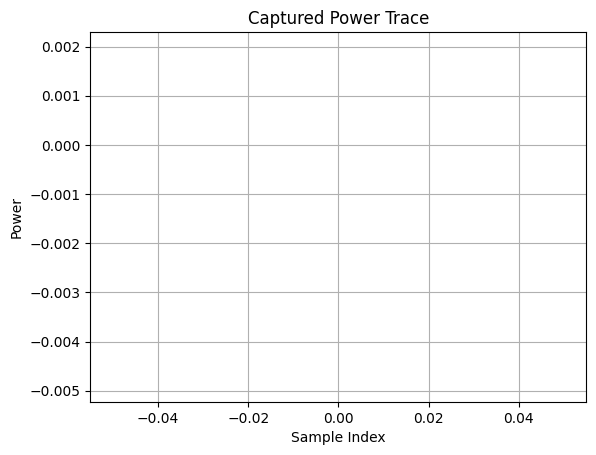

In [15]:
# Example: plot the waveform
waveform = data['wave']
plt.plot(waveform)
plt.title("Captured Power Trace")
plt.xlabel("Sample Index")
plt.ylabel("Power")
plt.grid(True)
plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1

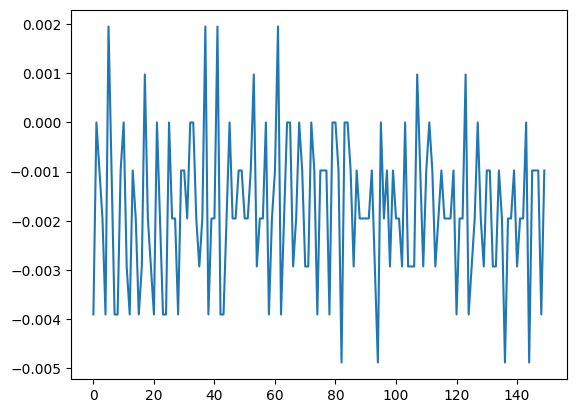

In [14]:
# multiple traces
for i in range(2):  # Plot first 2 traces
    plt.plot(data['wave'][i], label=f"Trace {i}")
plt.legend()
plt.title("Multiple Power Traces")
plt.xlabel("Sample Index")
plt.ylabel("Power")
plt.show()